In [1]:
import re 
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from analytics_utils.bigquery_utils import get_bq_client, BigQuery
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
STAGE_MAP = {
    'New': 1, 'Review': 2, 'Marked Relevant': 4, 
    'Opened': 2, 'Clicked': 2, 'Delivered': 4, 
    'Suppressed': 3, 'Dismissed': 3
}

REVERSE_STAGE_MAP = {
    1: 'New',
    2: 'Review',
    3: 'Dismissed',
    4: 'Marked Relevant'
}

DIM_MAP = {
    'Client': "fetch_recommendation_activity_customer", 
    'Client Industry': "Industry", 
    'Req Seniority': "dim_req_required_seniority_level", 
    'Req Top Category': "dim_req_top_category_calculated"
}

PATTERN_DELETE = r'(?=.+posit.+fill.+)|(?=.+posit.+interna.+)|(?=.+terna.+nly.+)|(?=.+interna.+fill.+)|(?=.+cand.+not.+interested.+)|(?=.+not.+reach.+)|(?=.+reach.+not.+)|(?=.+urrent.+employ.+)|(?=.*\bprocess\b.*\banother\b.*\breq\b)'

REASONS_TO_FILTER = {
    'other: Position will be filled internally ',
    'Candidate invited to apply',
    'In process in another req ',
    'Current Employee',
    'other: Position filled',
    'other: Internal only',
    'Qualified but candidate not interested at this time',
    
}

REASONS_TO_FILTER = {x.lower().strip() for x in REASONS_TO_FILTER}

def check_id(user_id):
    if user_id:
        if 'test' in user_id:
            return False
        elif str(user_id).endswith('-1'):
            return False
    return True

client_industry = pd.read_excel('planhat-companies-Oct-29-2023.xlsx')

In [37]:
def get_dataframe(from_date, to_date, account=None):
    db_client = get_bq_client('production')
    sql = f"""
        SELECT
            fact_recommendation_status_history.analytics_fetch_status_bucket  AS fact_recommendation_status_history_fetch_bucket,
            fetch_recommendation_activity.req_id  AS fetch_recommendation_activity_req_id,
            fetch_recommendation_activity.talent_id  AS fetch_recommendation_activity_talent_id,
            fact_recommendation_status_history.reason  AS fact_recommendation_status_history_reason,
            (DATE(fact_recommendation_status_history.status_ts )) AS fact_recommendation_status_history_status_at_date,
            fetch_recommendation_activity.customer  AS fetch_recommendation_activity_customer,
            dim_req.required_seniority_level  AS dim_req_required_seniority_level,
            dim_req.top_category  AS dim_req_top_category_calculated,
            fact_recommendation_status_history.user_id  AS fact_recommendation_status_history_user_id
        FROM `hs-analytics.all_customers.dwh_hs_dim_recommendation`
             AS fetch_recommendation_activity
        LEFT JOIN `hs-analytics.all_customers.dwh_hs_fact_recommendation_status_history`
             AS fact_recommendation_status_history ON fetch_recommendation_activity.key = fact_recommendation_status_history.recommendation_key
            and fetch_recommendation_activity.customer = fact_recommendation_status_history.customer
        FULL OUTER JOIN `hs-analytics.all_customers.dwh_hs_dim_req`
             AS dim_req ON dim_req.key = fetch_recommendation_activity.req_key
            and dim_req.customer = fetch_recommendation_activity.customer
        WHERE (fact_recommendation_status_history.analytics_fetch_status_bucket ) IN ('Dismissed', 'Marked Relevant', 'Review') 
         --   AND fetch_recommendation_activity.customer = "{account}"
            AND ((( fact_recommendation_status_history.status_ts  ) >= (TIMESTAMP("{str(from_date)}")) 
            AND ( fact_recommendation_status_history.status_ts  ) < (TIMESTAMP("{str(to_date)}")))) 
            AND (fetch_recommendation_activity.customer not in ( 'princeton',
                 'arizona_wd_staging',
                 'antigua',
                 'havana',
                 'seoul_icims',
                 'arizona' ))
        GROUP BY
            1,
            2,
            3,
            4,
            5,
            6,
            7,
            8,
            9
    """
    job_result = db_client.execute(sql)
    df = job_result['query_reults'].to_dataframe()
    df.to_csv('cache_dump.csv', index=None)
    df['Date'] = pd.to_datetime(df['fact_recommendation_status_history_status_at_date'])
    return df

In [38]:
def prepare_df(df):
    calc_df = df.copy()

    calc_df['Date'] = pd.to_datetime(calc_df['fact_recommendation_status_history_status_at_date'])
    for period in ('M', 'W', '2W'):
        calc_df[f'Period {period}'] = calc_df['Date'].dt.to_period(period)

    calc_df['bucket_code'] = calc_df['fact_recommendation_status_history_fetch_bucket'].map(STAGE_MAP)
    calc_df['pair_id'] = calc_df['fetch_recommendation_activity_req_id'].fillna('nan') + '_' + calc_df['fetch_recommendation_activity_talent_id'].fillna('nan')

    leads_to_filter = set(calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['pair_id'].values)


    calc_df[
        calc_df['fact_recommendation_status_history_reason'].fillna('').apply(
            lambda x: (bool(re.findall(PATTERN_DELETE, x.lower())) and ('qualif' not in x.lower())) or x.lower().strip() in REASONS_TO_FILTER
        )
    ]['bucket_code'] = STAGE_MAP['Marked Relevant']

    calc_df = calc_df[
        (~calc_df['pair_id'].isin(leads_to_filter)) & 
        (calc_df['fact_recommendation_status_history_user_id'].fillna('').apply(check_id))
    ]
    grouped_df = calc_df.groupby(
        ['pair_id'], as_index=False
    ).agg(
        {"bucket_code": "max",
         'fetch_recommendation_activity_req_id': 'first',
         'fetch_recommendation_activity_talent_id': 'first',
         'fetch_recommendation_activity_customer': 'first',
         'fact_recommendation_status_history_user_id': 'first',
         'Date': 'max',
         'Period M': 'max',
         'Period W': 'max',
         'Period 2W': 'max',     
         'dim_req_top_category_calculated': 'first',
         'dim_req_required_seniority_level': 'first',
        })

    grouped_df['Max Status Bucket'] = grouped_df['bucket_code'].map(REVERSE_STAGE_MAP)
    grouped_df = pd.concat([grouped_df, pd.get_dummies(grouped_df['Max Status Bucket'])], axis=1)
    grouped_df = grouped_df.dropna(subset=['Max Status Bucket'])

    client_industry['Account Name'] = client_industry['Account Name'].str.lower()
    grouped_df = pd.merge(grouped_df, client_industry, 
                          left_on='fetch_recommendation_activity_customer', 
                          right_on='Account Name', how='left')
    return grouped_df

In [40]:
raw_df = get_dataframe(date(2023, 6, 1), date(2024, 12, 28))
raw_df.shape

(505722, 10)

In [51]:
gb = ['after', 'fact_recommendation_status_history_user_id', 'dim_req_top_category_calculated']

/var/folders/_p/8_m91crj199_rd7sndkxncc80000gp/T/ipykernel_42662/3353077257.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc_df[


Before: 0.7555778645442258 [0.74823359 0.76332783]
After: 0.5064939930920559 [0.49812096 0.51494406]


<Figure size 1300x500 with 0 Axes>

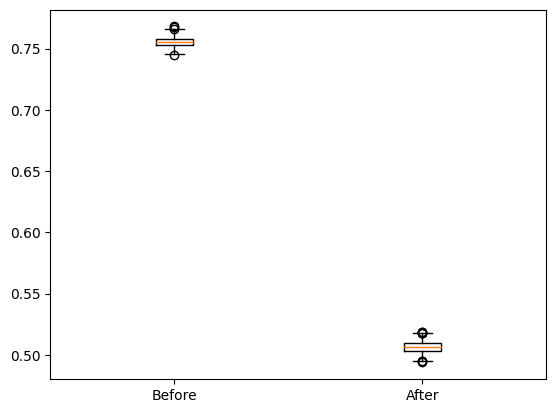

In [61]:
ACCOUNT = 'dallas'
TEST_DATE = datetime(2024, 1, 16)
prep_df = prepare_df(raw_df[raw_df['fetch_recommendation_activity_customer'] == ACCOUNT])

curr_date = TEST_DATE
prep_df['after'] = prep_df['Date'] > curr_date
prep_df['after'].mean()
xdf = prep_df.groupby(gb).sum()[['Marked Relevant', 'Dismissed', 'Review']].reset_index()
xdf['total'] = xdf['Marked Relevant'] + xdf['Dismissed'] + xdf['Review']
xdf['rate'] = xdf['Marked Relevant'] / xdf['total']

rates = xdf.set_index(gb)[['rate', 'Marked Relevant', 'Dismissed', 'Review', 'total']].unstack(0)#.dropna()

rates = rates[(rates[('total', False)] > 10) & (rates[('total', True)] > 10)]
before_rate = rates[('Marked Relevant', False)].sum() / rates[('total', False)].sum()
after_rate = rates[('Marked Relevant', True)].sum() / rates[('total', True)].sum()

before_population = ['relevant']*int(rates[('Marked Relevant', False)].sum()) + ['dismissed']*int(rates[('Dismissed', False)].sum()) + ['dismissed']*int(rates[('Review', False)].sum())
after_population = ['relevant']*int(rates[('Marked Relevant', True)].sum()) + ['dismissed']*int(rates[('Dismissed', True)].sum()) + ['dismissed']*int(rates[('Review', True)].sum())

bootstrap_before_rates = []
bootstrap_after_rates = []

for _ in range(1000):
    before_sample = Counter(np.random.choice(before_population, size=len(before_population), replace=True))
    after_sample = Counter(np.random.choice(after_population, size=len(before_population), replace=True))

    bs_before_rate = before_sample['relevant'] / sum(before_sample.values())
    bs_after_rate = after_sample['relevant'] / sum(after_sample.values())

    bootstrap_before_rates.append(bs_before_rate)
    bootstrap_after_rates.append(bs_after_rate)

    
print('Before:', np.mean(bootstrap_before_rates), np.percentile(bootstrap_before_rates, [2.5, 97.5]))
print('After:', np.mean(bootstrap_after_rates), np.percentile(bootstrap_after_rates, [2.5, 97.5]))


fig = plt.figure(figsize=(13, 5))
fig, ax = plt.subplots()
ax.boxplot([bootstrap_before_rates, bootstrap_after_rates])
ax.set_xticks([1, 2])
_ = ax.set_xticklabels(['Before', 'After'])

In [58]:
xdf.set_index(gb)[['rate', 'Marked Relevant', 'Dismissed', 'Review', 'total']].unstack(0).dropna()

rate  \
after                                                                                  False   
fact_recommendation_status_history_user_id         dim_req_top_category_calculated             
JLL-01757d5f-8bcb-4ca7-aa4e-d9c698f549cb-168482... Maintenance_&_Repair             0.150510   
JLL-0abf83e2-19eb-4c14-adeb-d732e9a2e2e1-168543... Accounting_&_Finance             0.021965   
JLL-12fcdbaa-04eb-46a2-9c68-61e51c32c218-168494... Administrative                   1.000000   
                                                   Maintenance_&_Repair             0.991544   
JLL-337ddfea-2fe4-4313-b5bb-9e3c5e1416ac-168430... Engineering                      0.088235   
...                                                                                      ...   
JLL87                                              IT_&_Software_Development        0.250000   
JLL90                                              Building_&_Construction          0.222892   
                                                   Engineering                      0.200000   
JLL92                                              Manufacturing                    0.212121   
JLL96                                              Sales                            0.176471   

                                                                                              \
after                                                                                   True   
fact_recommendation_status_history_user_id         dim_req_top_category_calculated             
JLL-01757d5f-8bcb-4ca7-aa4e-d9c698f549cb-168482... Maintenance_&_Repair             0.230769   
JLL-0abf83e2-19eb-4c14-adeb-d732e9a2e2e1-168543... Accounting_&_Finance             0.000000   
JLL-12fcdbaa-04eb-46a2-9c68-61e51c32c218-168494... Administrative                   1.000000   
                                                   Maintenance_&_Repair             1.000000   
JLL-337ddfea-2fe4-4313-b5bb-9e3c5e1416ac-168430... Engineering                      0.760000   
...                                                                                      ...   
JLL87                                              IT_&_Software_Development        0.000000   
JLL90                                              Building_&_Construction          0.400000   
                                                   Engineering                      0.000000   
JLL92                                              Manufacturing                    0.000000   
JLL96                                              Sales                            0.062500   

                                                                                   Marked Relevant  \
after                                                                                        False   
fact_recommendation_status_history_user_id         dim_req_top_category_calculated                   
JLL-01757d5f-8bcb-4ca7-aa4e-d9c698f549cb-168482... Maintenance_&_Repair                       59.0   
JLL-0abf83e2-19eb-4c14-adeb-d732e9a2e2e1-168543... Accounting_&_Finance                       19.0   
JLL-12fcdbaa-04eb-46a2-9c68-61e51c32c218-168494... Administrative                            367.0   
                                                   Maintenance_&_Repair                     6918.0   
JLL-337ddfea-2fe4-4313-b5bb-9e3c5e1416ac-168430... Engineering                                 3.0   
...                                                                                            ...   
JLL87                                              IT_&_Software_Development                   2.0   
JLL90                                              Building_&_Construction                    37.0   
                                                   Engineering                                 3.0   
JLL92                                              Manufacturing                               7.0   
JLL96                                              Sales                

In [93]:
rates.shape

(26, 10)

In [81]:
prep_df.head()

,pair_id,bucket_code,fetch_recommendation_activity_req_id,fetch_recommendation_activity_talent_id,fetch_recommendation_activity_customer,fact_recommendation_status_history_user_id,Date,Period M,Period W,Period 2W,dim_req_top_category_calculated,dim_req_required_seniority_level,Max Status Bucket,Dismissed,Marked Relevant,Review,Account Name,Industry,after
0,JLLREQ153424_3852ef24-c4d1-44c9-b9ae-b5f62a663dbe,2,JLLREQ153424,3852ef24-c4d1-44c9-b9ae-b5f62a663dbe,jaipur,JLL321,2023-06-06,2023-06,2023-06-05/2023-06-11,2023-06-05/2023-06-11,Maintenance_&_Repair,junior,Review,0,0,1,jaipur,Real Estate,False
1,JLLREQ227447_1e7b6486-5f87-4a79-b76a-e7a3e469b7f2,4,JLLREQ227447,1e7b6486-5f87-4a79-b76a-e7a3e469b7f2,jaipur,JLL-12fcdbaa-04eb-46a2-9c68-61e51c32c218-16849...,2023-12-13,2023-12,2023-12-11/2023-12-17,2023-12-11/2023-12-17,Maintenance_&_Repair,manager,Marked Relevant,0,1,0,jaipur,Real Estate,False
2,JLLREQ243371_014206a7-31fc-492f-86cf-808944fc6fed,4,JLLREQ243371,014206a7-31fc-492f-86cf-808944fc6fed,jaipur,JLL224,2023-08-07,2023-08,2023-08-07/2023-08-13,2023-08-07/2023-08-13,Maintenance_&_Repair,junior,Marked Relevant,0,1,0,jaipur,Real Estate,False
3,JLLREQ243371_04bd7c3c-053b-4bac-878b-273098203f01,4,JLLREQ243371,04bd7c3c-053b-4bac-878b-273098203f01,jaipur,JLL224,2023-08-07,2023-08,2023-08-07/2023-08-13,2023-08-07/2023-08-13,Maintenance_&_Repair,junior,Marked Relevant,0,1,0,jaipur,Real Estate,False
4,JLLREQ243371_0534c6cc-16e6-450e-8900-b09f3be1082e,4,JLLREQ243371,0534c6cc-16e6-450e-8900-b09f3be1082e,jaipur,JLL224,2023-08-07,2023-08,2023-08-07/2023-08-13,2023-08-07/2023-08-13,Maintenance_&_Repair,junior,Marked Relevant,0,1,0,jaipur,Real Estate,False


In [82]:
prep_df['user_cat_pair'] = prep_df['fact_recommendation_status_history_user_id'] + prep_df['dim_req_top_category_calculated']

In [90]:
after_df = prep_df[prep_df['Date'] > curr_date]
before_df= prep_df[prep_df['Date'] < curr_date]

In [92]:
relevant_pairs = set(after_df['user_cat_pair'].value_counts().loc[lambda x: x > 10].index) & set(before_df['user_cat_pair'].value_counts().loc[lambda x: x > 10].index)
len(relevant_pairs)

26

In [97]:
def calc_rate(ddf):
    return ddf['Marked Relevant'].sum() / (ddf['Marked Relevant'] + ddf['Dismissed'] + ddf['Review']).sum()

In [99]:
calc_rate(before_df), calc_rate(after_df)

(0.5154855643044619, 0.4228538283062645)